# Mechanistic modeling of VMHvl line attractor dynamics

By Charles Xu @ Caltech, 2024.

This notebook builds on the work by Isa in 2024 to further generalize on other plausible mechanisms of the implementation of the VMHvl line attractor.

## Environment

In [41]:
from vmhvl_snn_sim import VMHvlSNNSimulation
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as stats
import pickle

## Local slow dynamics model

In [34]:
# Create an instance of the simulation class with example percentages
snn = VMHvlSNNSimulation(0.1, 0.0,
                         N=1000,
                         threshold=0.1,
                         v_r=0,
                         tau_s=2e3,
                         n_pulses=4,
                         g_input=5,
                         dt=0.005e3,
                         simulation_time=200e3,
                         noise=0.1)

# Run the simulation
snn.run_simulation()

Initializing simulation...
Simulating...
Simulation time: 30/199996 ms

Simulation time: 199995/199996 ms
Simulation complete.


In [42]:
# Save simulation object
save_path = 'snn.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(snn, f)
print(f'Simulation object saved to {save_path}')

Simulation object saved to snn.pkl


In [43]:
# Read simulation object
with open(save_path, 'rb') as f:
    snn = pickle.load(f)
print(f'Simulation object loaded from {save_path}')

Simulation object loaded from snn.pkl


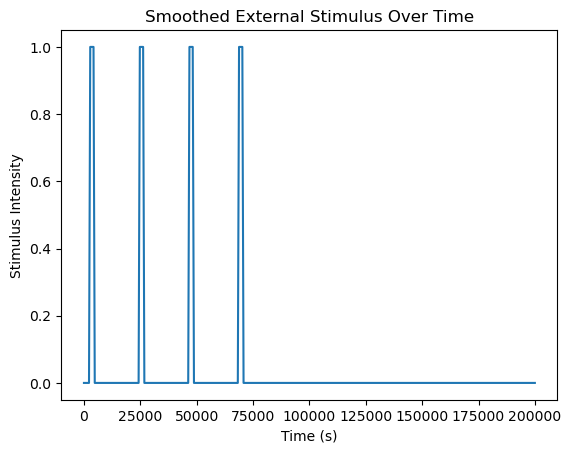

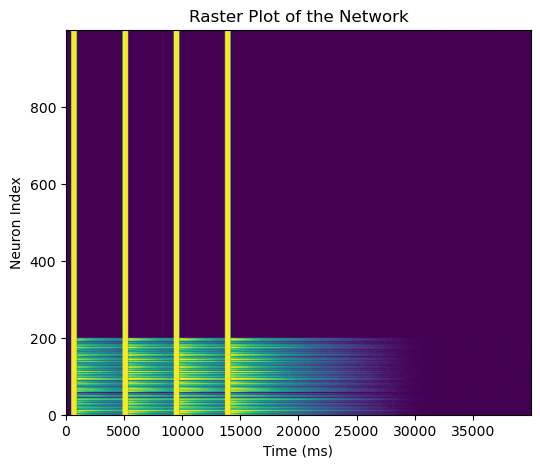

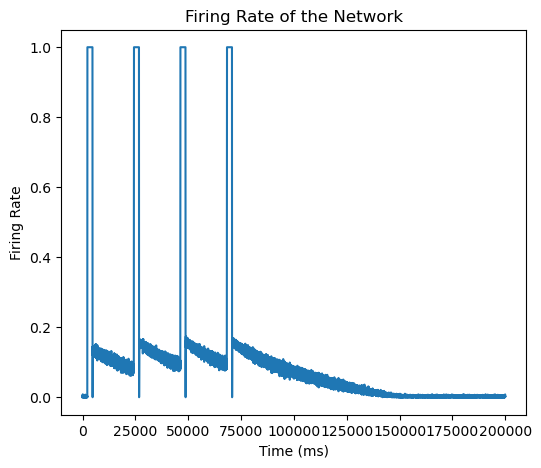

In [35]:
# Plot the stimulus
snn.plot_stimulus()

# Plot the simulation results
snn.plot_raster()
snn.plot_network_rate()

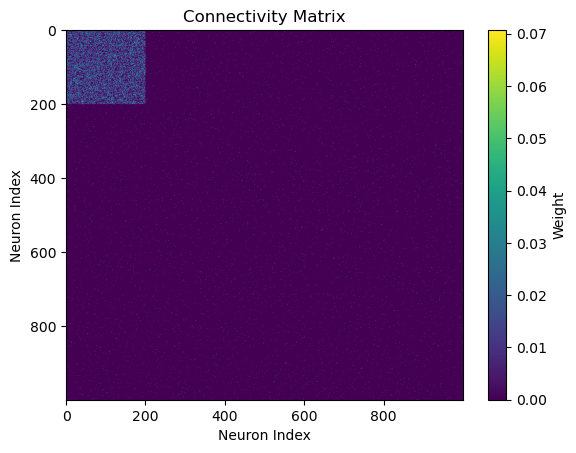

In [36]:
# Plot the connectivity matrix
plt.imshow(snn.W, cmap='viridis', aspect='auto')
plt.colorbar(label='Weight')
plt.title('Connectivity Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

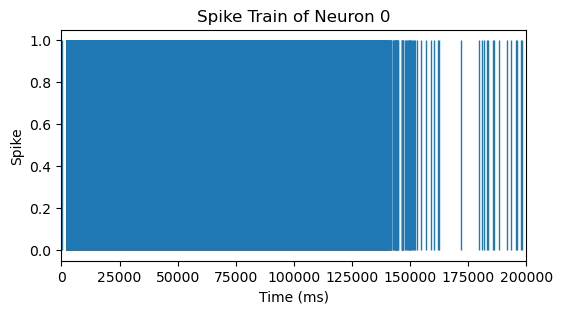

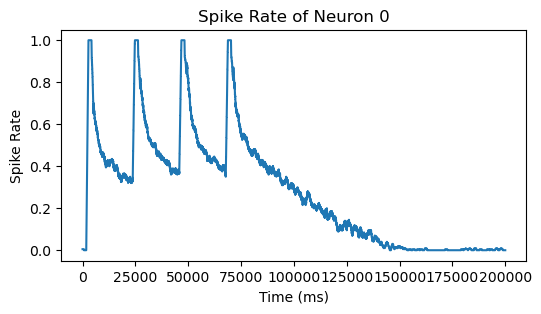

In [37]:
# Plot individual spike trains
snn.plot_spike_train()
snn.plot_spike_rate()

## Fitted degree distribution model

In [38]:
# Read and process the connectivity distributions
dist_mat_path = 'distribution_pairwise_vinograd_nair.mat'
dist_mat = sio.loadmat(dist_mat_path)
dist_x1 = dist_mat['all_dist_mean_x1']
dist_x2 = dist_mat['all_dist_mean_x2']
dist_x1 = np.squeeze(dist_x1)
dist_x2 = np.squeeze(dist_x2)

### Fit the distributions

Exponential distribution KS statistic on x1: 0.37378708688240136, p-value: 1.522686568778958e-10
Gamma distribution KS statistic on x1: 0.08728836068538459, p-value: 0.5464469453535334


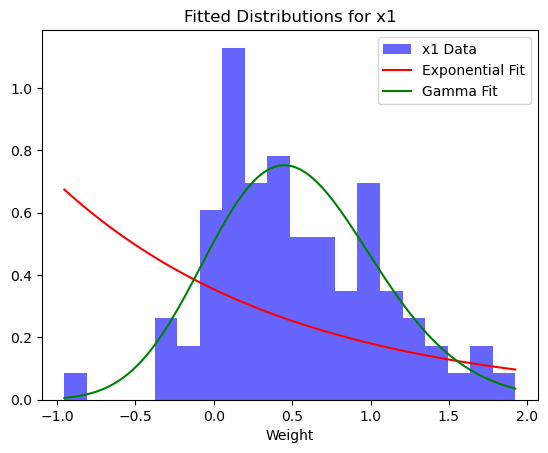

In [39]:
## Fit for x1 population

# Fit parameters
x1_exp_fit = stats.expon.fit(dist_x1)
x1_gamma_fit = stats.gamma.fit(dist_x1)

# Goodness of fit
x1_exp_ks = stats.kstest(dist_x1, 'expon', args=x1_exp_fit)
x1_gamma_ks = stats.kstest(dist_x1, 'gamma', args=x1_gamma_fit)
print(f'Exponential distribution KS statistic on x1: {x1_exp_ks[0]}, p-value: {x1_exp_ks[1]}')
print(f'Gamma distribution KS statistic on x1: {x1_gamma_ks[0]}, p-value: {x1_gamma_ks[1]}')

# Plot the histogram and the fitted distributions
x = np.linspace(np.min(dist_x1), np.max(dist_x1), 100)
x1_exp_pdf = stats.expon.pdf(x, *x1_exp_fit)
x1_gamma_pdf = stats.gamma.pdf(x, *x1_gamma_fit)
plt.hist(dist_x1, bins=20, density=True, alpha=0.6, color='b', label='x1 Data')
plt.plot(x, x1_exp_pdf, 'r-', label='Exponential Fit')
plt.plot(x, x1_gamma_pdf, 'g-', label='Gamma Fit')
plt.xlabel('Weight')
plt.legend()
plt.title('Fitted Distributions for x1')
plt.show()

Exponential distribution KS statistic on x2: 0.35192278270722177, p-value: 3.008171224219629e-11
Gamma distribution KS statistic on x2: 0.07874410533157322, p-value: 0.557533510696288


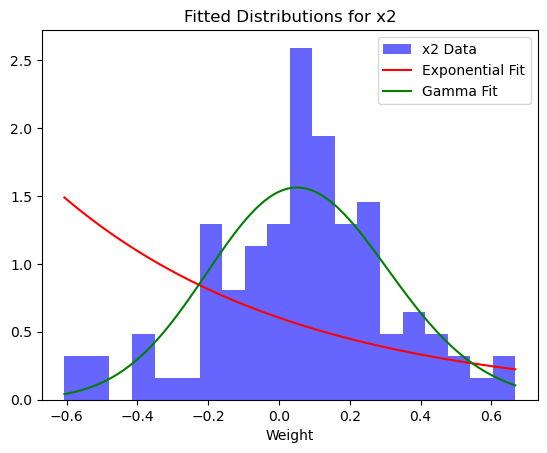

In [40]:
## Fit for x2 population

# Fit parameters
x2_exp_fit = stats.expon.fit(dist_x2)
x2_gamma_fit = stats.gamma.fit(dist_x2)

# Goodness of fit
x2_exp_ks = stats.kstest(dist_x2, 'expon', args=x2_exp_fit)
x2_gamma_ks = stats.kstest(dist_x2, 'gamma', args=x2_gamma_fit)
print(f'Exponential distribution KS statistic on x2: {x2_exp_ks[0]}, p-value: {x2_exp_ks[1]}')
print(f'Gamma distribution KS statistic on x2: {x2_gamma_ks[0]}, p-value: {x2_gamma_ks[1]}')

# Plot the histogram and the fitted distributions
x = np.linspace(np.min(dist_x2), np.max(dist_x2), 100)
x2_exp_pdf = stats.expon.pdf(x, *x2_exp_fit)
x2_gamma_pdf = stats.gamma.pdf(x, *x2_gamma_fit)

plt.hist(dist_x2, bins=20, density=True, alpha=0.6, color='b', label='x2 Data')
plt.plot(x, x2_exp_pdf, 'r-', label='Exponential Fit')
plt.plot(x, x2_gamma_pdf, 'g-', label='Gamma Fit')
plt.xlabel('Weight')
plt.legend()
plt.title('Fitted Distributions for x2')
plt.show()